## Loading The Required Libraries

In [1]:
import pandas as pd
import requests
from io import StringIO
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import community.community_louvain as community_louvain
import matplotlib.cm as cm
import networkx.algorithms.community as nx_comm
from collections import defaultdict
from operator import itemgetter
from networkx.algorithms import community

## Loading The Dataset From GitHub

In [2]:
github_username = 'amr-mnrashad'
repository_name = 'SNA-Thesis-Project'
api_url = f'https://api.github.com/repos/{github_username}/{repository_name}/contents/Dataset'

- The aim of the following code is to load the csv files stored in my GitHub repository and store them in a single dataframe called 'merged_df'.
- There is the option to select the number of rows or the number of csv files desired to be stored in the dataframe. The reason is I was interested in doing some trials on a smaller dataset size

In [24]:
def load_csv_from_github(file_url):
    response = requests.get(file_url)
    if response.status_code == 200:
        content = response.content
        df = pd.read_csv(StringIO(content.decode('utf-8')))
        return df.head(1000)  # Number of rows desired to take from each csv file
    else:
        print(f"Failed to fetch {file_url}")
        return None

response = requests.get(api_url)
if response.status_code == 200:
    content = response.json()
    print("Files in Dataset directory:")
    dfs = []  # Initializing an empty list to store dataframes of each csv file
    count = 0  # Initializing a counter to keep track of the processed files
    for file_info in content:
        print(file_info['name'])
        if file_info['name'].endswith('.csv'):
            csv_url = file_info['download_url']
            df = load_csv_from_github(csv_url)
            if df is not None:
                dfs.append(df)
                count += 1
                if count >= 100:  # Number of csv files desired to store in my dataframe
                    break
else:
    print(f"Failed to fetch directory contents. Status code: {response.status_code}")

# Concatenating all dataframes into a single one to make it easier for me to do some data preprocessing
if dfs:
    merged_df = pd.concat(dfs, ignore_index=True)
    print("Merging successful.")
else:
    print("No CSV files found in the Dataset directory.")

Files in Dataset directory:
AdviceAnimals_data.csv
AmItheAsshole_data.csv
AnimalsBeingBros_data.csv
AnimalsBeingDerps_data.csv
AnimalsBeingJerks_data.csv
Art_data.csv
AskReddit_data.csv
AskWomen_data.csv
Awwducational_data.csv
BeAmazed_data.csv
Bitcoin_data.csv
BlackPeopleTwitter_data.csv
ContagiousLaughter_data.csv
CryptoCurrency_data.csv
DIY_data.csv
Damnthatsinteresting_data.csv
Documentaries_data.csv
EarthPorn_data.csv
EatCheapAndHealthy_data.csv
Fitness_data.csv
FoodPorn_data.csv
Futurology_data.csv
GetMotivated_data.csv
HistoryMemes_data.csv
IAmA_data.csv
InternetIsBeautiful_data.csv
Jokes_data.csv
LifeProTips_data.csv
MadeMeSmile_data.csv
Minecraft_data.csv
Music_data.csv
NatureIsFuckingLit_data.csv
OldSchoolCool_data.csv
PS4_data.csv
Parenting_data.csv
Showerthoughts_data.csv
Tinder_data.csv
TwoXChromosomes_data.csv
Unexpected_data.csv
UpliftingNews_data.csv
WTF_data.csv
WatchPeopleDieInside_data.csv
Whatcouldgowrong_data.csv
WritingPrompts_data.csv
anime_data.csv
askscience_da

## Creating Graph Dataframe

- The aim of this section is to create a clean dataframe that will be used to create my networkx graph. The dataframe created is graph_df.
- A new column is created which stores users who posted and users who commented into a single list. If the user who posted also commented, then only one unique ID will be in the list, as I have removed duplicates.
- Other columns have been dropped such as 'Downvotes' column and 'User ID' and 'Users Who Commented'
- graph_df is a copy of the cleaned merged_df, in order to ensure that graph_df is independent

In [25]:
merged_df.head()

,Subreddit,Population,Post Title,User ID,Users Who Commented,Upvotes,Date,Time,Downvotes
0,AdviceAnimals,9834809,It’s really not that hard to figure out,TwoPercentTokes,"jezra,alejo699,TrinixDMorrison,squeeeeenis,myc...",97106,2022-08-31,22:03:49,NaN
1,AdviceAnimals,9834809,Chrome says that they're no longer allowing ad...,ElderCunningham,"chrysrobyn,lotsofdeadkittens,Tony_Cheese_,Squa...",86334,2022-08-24,18:27:29,NaN
2,AdviceAnimals,9834809,"EU, plz gib more monies...",bamamabuam,"trystanthorne,guspaz,TheMacroorchidism,craftwo...",71850,2023-02-09,17:27:19,NaN
3,AdviceAnimals,9834809,Just be safe.,ohnodopey,"doxamully,ratcliffeb,MisssJaynie,LegendOfBobby...",70897,2022-12-31,17:42:26,NaN
4,AdviceAnimals,9834809,Major “breastfed until they were eight” energy,SoylentCreek,"Red_Carrot,ken27238,Cold_Kaleidoscope354,TheFu...",68948,2023-06-10,01:40:24,NaN


In [26]:
merged_df['Subreddit_Users'] = merged_df['User ID'] + ',' + merged_df['Users Who Commented']
merged_df = merged_df.rename(columns={'Post Title': 'Post_Title'})
merged_df['Users_List'] = merged_df['Subreddit_Users'].str.split(',')
merged_df = merged_df.drop(columns=['Downvotes', 'User ID', 'Users Who Commented', 'Subreddit_Users'])
merged_df = merged_df.dropna(subset=['Users_List'])
merged_df['Users_List'] = merged_df['Users_List'].apply(lambda users_list: list(set(users_list)))
graph_df = merged_df.copy()
graph_df.head()

,Subreddit,Population,Post_Title,Upvotes,Date,Time,Users_List
0,AdviceAnimals,9834809,It’s really not that hard to figure out,97106,2022-08-31,22:03:49,"[TrippenCracker, lunatic_paranoia, jfk_47, all..."
1,AdviceAnimals,9834809,Chrome says that they're no longer allowing ad...,86334,2022-08-24,18:27:29,"[TheQuiet1994, brothersand, Jazz7770, Soul-Bur..."
2,AdviceAnimals,9834809,"EU, plz gib more monies...",71850,2023-02-09,17:27:19,"[djaun3004, Dycondrius, D-Fence, teleheaddawgf..."
3,AdviceAnimals,9834809,Just be safe.,70897,2022-12-31,17:42:26,"[prodigy1367, RubenMuro007, ZzeroBeat, TypePsy..."
4,AdviceAnimals,9834809,Major “breastfed until they were eight” energy,68948,2023-06-10,01:40:24,"[FurnaceFuneral, avotoastlover, GayNerd28, her..."


- After creating graph_df, due to the large size of the dataset, I decided to keep only the active user Ids in the 'Users_List' column, by active I mean a user ID that appears at least 50 times in a subreddit group. Example User A appears 50 times in Subreddit X, meaning the user ID is listed in 50 rows where the subreddit column value is X.
- Few trials have been made to establish what could an optimal threshold that would result in a large enough dataset that can be processed on a single machine. I started with 100 and went down to 10 gradually, however the best one that results in a good dataset size and graph size as well is 50.

In [27]:
# Aim of this function is to return the list of active users
def filter_users(users_list, subreddit):
    active_users_subreddit = set(active_users[active_users['Subreddit'] == subreddit]['Users_List'])
    return list(set(users_list) & active_users_subreddit)  # Use set intersection to remove duplicates

In [ ]:
# Here I count the occurrences of each user ID in a subreddit
user_counts = graph_df.explode('Users_List').groupby(['Users_List', 'Subreddit']).size().reset_index(name='Count')

# Here I identify the users who appear at least 50 times in a subreddit
active_users = user_counts[user_counts['Count'] >= 50]

#Then I perform the filteration and just keep the active users in my 'Users_List' column
graph_df['Users_List'] = graph_df.apply(lambda row: filter_users(row['Users_List'], row['Subreddit']), axis=1)

# If the Users_List is empty I drop the row
graph_df = graph_df[graph_df['Users_List'].map(len) > 0]

graph_df.head()

## Creating Graph

- The aim of this part is to create my undirected graph from graph_df. Where The user ids in my 'Users_List' column are my nodes and two users would be linked together if they have been active on a common subreddit, the word active here means either posted or commented.

In [30]:
def create_graph(df):
    G = nx.Graph()
    
    # Here I start by adding the nodes to my empyt graph
    for index, row in df.iterrows():
        users = row['Users_List']
        for user in users:
            G.add_node(user)
    
    print("Nodes are added to the graph successfully")
    
    # Here I start by Adding edges to the graph based on the subreddit interactions
    for subreddit in df['Subreddit'].unique():
        subreddit_users = df[df['Subreddit'] == subreddit]['Users_List']
        for users_list in subreddit_users:
            for user1 in users_list:
                for user2 in users_list:
                    if user1 != user2:
                        G.add_edge(user1, user2, subreddit=subreddit)
    
    print("Edges are added to the graph successfully")
    
    return G

In [31]:
subreddits_graph = create_graph(graph_df)

Nodes are added to the graph successfully
Edges are added to the graph successfully


In [32]:
num_nodes = subreddits_graph.number_of_nodes()
num_edges = subreddits_graph.number_of_edges()

print(f"Number of nodes in the graph: {num_nodes}")
print(f"Number of edges in the graph: {num_edges}")

Number of nodes in the graph: 5137
Number of edges in the graph: 547962


## Saving Graph Nodes & Edges In Two CSV Files

- The aim of this part is to store my graph in two csv files (nodes and edges) in order to perform some visualizations on Gephi and also in order to create a sort of checkpoint that I can start from, instead of starting from the beginning each time.

In [12]:
from google.colab import files

In [33]:
# Saving the edges as a CSV file with only 'source' and 'target' columns
edges_file_path = 'edges.csv'
edges_data = subreddits_graph.edges()
edges_df = pd.DataFrame(edges_data, columns=['source', 'target'])
edges_df.to_csv(edges_file_path, index=False)

In [34]:
# Saving the nodes with the attributes in seperate columns as a CSV file
nodes_file_path = 'nodes.csv'
nodes_data = [{'Node': node} for node in subreddits_graph.nodes()]
nodes_df = pd.DataFrame(nodes_data, columns=['Node'])
nodes_df.to_csv(nodes_file_path, index=False)

In [ ]:
edges_file_path = 'edges.csv'
nodes_file_path = 'nodes.csv'
files.download(edges_file_path)
files.download(nodes_file_path)

In [ ]:
graph_file_path = 'subreddits_graph.graphml'
nx.write_graphml(subreddits_graph, graph_file_path)
files.download(graph_file_path)

## Loading The Graph

- This section is a checkpoint

In [ ]:
# Loading the graph with node and edge attributes
graph_file_path = 'subreddits_graph.graphml'
loaded_graph = nx.read_graphml(graph_file_path)

# Double checking the number of nodes and edges after loading both nodes and edges
num_nodes = loaded_graph.number_of_nodes()
num_edges = loaded_graph.number_of_edges()

print(f"Number of nodes in the graph: {num_nodes}")
print(f"Number of edges in the graph: {num_edges}")

## Network Analysis

- This part is not yet complete, however it's a starting point

In [43]:
#Few network statistics
degree = subreddits_graph.degree
subreddits_graph_degree_dict = dict(subreddits_graph.degree)
subreddits_graph_degree_list = list(dict(subreddits_graph.degree()).values())
density = nx.density(subreddits_graph)
subreddits_degree_view=subreddits_graph.degree()
subreddits_degree=list(dict(subreddits_graph.degree()).values())

print("Mean: ", np.mean(subreddits_graph_degree_list))
print("Median: ",np.median(subreddits_graph_degree_list))
print("Standard deviation: ",np.std(subreddits_graph_degree_list))
print("Max: ",np.max(subreddits_graph_degree_list))
print("Min: ",np.min(subreddits_graph_degree_list))
print('Network Density: ', density)
print('transitivity: {}'.format(nx.transitivity(subreddits_graph)))

Mean:  213.33930309519175
Median:  169.0
Standard deviation:  169.61255049471768
Max:  2813
Min:  1


In [44]:
# print(type(subreddits_degree_view))
# print(subreddits_degree_view)
# print('\n',type(subreddits_degree))
# print(subreddits_degree)

Text(0, 0.5, 'ECCDF')

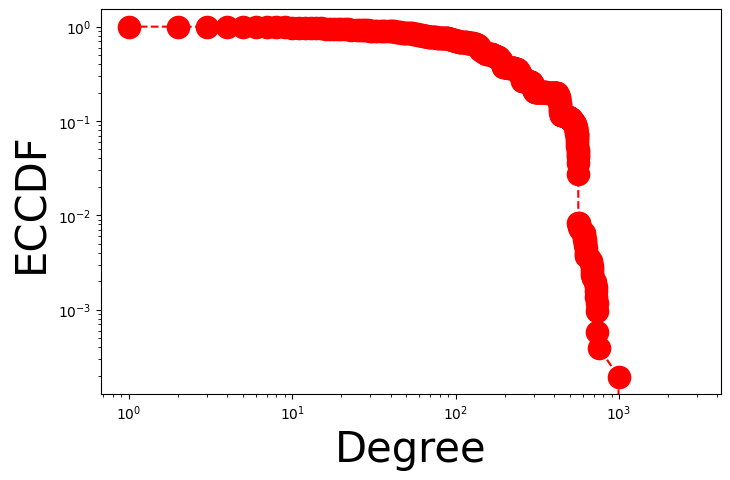

In [40]:
cdf_function = ECDF(subreddits_degree)
x = np.unique(subreddits_degree)
# ECCDF in loglog scale
y = 1-cdf_function(x)
fig_ccdf_function = plt.figure(figsize=(8,5))
axes = fig_ccdf_function.gca()
axes.loglog(x,y,color = 'red', linestyle = '--', marker= 'o',ms = 16)
axes.set_xlabel('Degree',size = 30)
axes.set_ylabel('ECCDF',size = 30)

In [21]:
percentile_95 = np.percentile(subreddits_degree,95)
print(percentile_95)

563.0


In [41]:
hub_nodi = [k for k,v in dict(subreddits_graph.degree()).items() if v>= percentile_95]
print(hub_nodi)

['Technologhee', 'AutoModerator', 'Explodicle', 'TheGreatest34567', 'KAX1107', 'Rey_Mezcalero', 'sylsau', 'Rtbrosk', 'Dazzling_Marzipan474', 'zesushv', 'bittabet', 'Jin-Sakti', 'sebikun', 'Hank___Scorpio', 'fnetma', 'ChrysMYO', 'FuckingKilljoy', 'DLottchula', 'TheMoorNextDoor', 'ShotCryptographer523', 'TruthSeeekeer', 'lycheedorito', 'pmbuttsonly', 'Odlavso', 'TheTrueBlueTJ', 'Lord-Nagafen', 'Lillica_Golden_SHIB', 'Odysseus_Lannister', 'deathbyfish13', 'valz_', 'meeleen223', 'Cactuszach', 'H__Dresden', 'evoxyseah', 'ChemicalGreek', 'DDDUnit2990', 'MaeronTargaryen', 'genjitenji', 'Cheese6260', 'Red5point1', 'Harold838383', 'Marrr_ty', 'coinfeeds-bot', 'The_Chorizo_Bandit', 'Kappatalizable', 'coinsRus-2021', 'AromaticCarob', 'explision', 'moldyjellybean', 'ahabraken', 'reddito321', 'CymandeTV', 'Wonzky', 'DadofHome', 'Mr_Bob_Ferguson', 'Alanski22', 'FldLima', 'Hawke64', 'jwz9904', 'milonuttigrain', 'LazyEdict', 'mikeoxwells2', 'SilasX', 'pizza-chit', 'irockalltherocks', 'user260421', 'ma

In [45]:
print('dictionary keyed by nodes: number of triangles {}'.format(nx.triangles(subreddits_graph)))

dictionary keyed by nodes: number of triangles {'tacknosaddle': 3985, 'SgtDoughnut': 3318, 'Seiglerfone': 1585, 'sloopslarp': 14609, 'Killbot_Wants_Hug': 1638, 'Lost-My-Mind-': 12632, 'JasonDJ': 1638, '444unsure': 1718, 'WikiSummarizerBot': 5171, 'TestPattern2': 1638, 'LeoMarius': 1638, 'GopnikSmegmaBBQSauce': 1638, 'Thendofreason': 1638, 'SilentSamurai': 1531, 'Mccobsta': 1638, 'All_Work_All_Play': 3665, 'PillowTalk420': 9863, 'zaphodava': 1638, 'Technologhee': 148187, 'Purplociraptor': 1582, 'MathMaddox': 2013, 'temalyen': 1638, 'nubsauce87': 1638, 'mortalcoil1': 8900, 'spagbetti': 1638, 'ActualMis': 1585, 'processedmeat': 1638, 'westwoo': 1638, 'socokid': 11941, '3-DMan': 4945, 'occamsrzor': 1638, 'Gorstag': 1638, 'TheMooseIsBlue': 1684, 'G8kpr': 11720, 'Piemaster113': 1638, 'N8CCRG': 8790, 'Raider-bob': 1638, 'TylerDurdenUMD': 6471, 'Joliet_Jake_Blues': 11497, 'Huegod': 1531, 'chocki305': 1638, 'RudegarWithFunnyHat': 3080, 'Evilmaze': 2088, 'Slurm818': 1638, '420BongHitsForJesus': 

In [47]:
print('local clustering: {}'.format(nx.clustering(subreddits_graph)))

local clustering: {'tacknosaddle': 0.46090677770067084, 'SgtDoughnut': 0.5061784897025171, 'Seiglerfone': 0.9931077694235589, 'sloopslarp': 0.6064342050643421, 'Killbot_Wants_Hug': 0.9909255898366606, 'Lost-My-Mind-': 0.2706953819779278, 'JasonDJ': 0.9909255898366606, '444unsure': 0.6913480885311871, 'WikiSummarizerBot': 0.23563454089769878, 'TestPattern2': 0.9909255898366606, 'LeoMarius': 0.9909255898366606, 'GopnikSmegmaBBQSauce': 0.9909255898366606, 'Thendofreason': 0.9909255898366606, 'SilentSamurai': 0.9941558441558441, 'Mccobsta': 0.9909255898366606, 'All_Work_All_Play': 0.5133053221288515, 'PillowTalk420': 0.22287754502519602, 'zaphodava': 0.9909255898366606, 'Technologhee': 0.800422392187365, 'Purplociraptor': 0.9912280701754386, 'MathMaddox': 0.5638655462184874, 'temalyen': 0.9909255898366606, 'nubsauce87': 0.9909255898366606, 'mortalcoil1': 0.577922077922078, 'spagbetti': 0.9909255898366606, 'ActualMis': 0.9931077694235589, 'processedmeat': 0.9909255898366606, 'westwoo': 0.99

In [48]:
#Average Local Clustering:
nx.average_clustering(subreddits_graph), np.mean(list(nx.clustering(subreddits_graph).values()))

(0.9514644199043258, 0.9514644199043372)

In [49]:
np.median(list(nx.triangles(subreddits_graph).values()))

12701.0

## Data Exploratory Analysis

## Community Detection

## PageRank

## Recommendation System